In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src/')

import torch
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt


from utils import cartesian_grid
from dataset import Datagen
from solver import optimalSolution
from terminal_models import ValueModelUnicycle
from value_approximator import ValueApproximator
from policy_approximator import StatePolicyApproximator
torch.set_default_dtype(torch.float)

In [3]:
policy_net1_5000 = torch.load('../src/neural_networks/sampled/policy_net2_5000.pth')
policy_net2_5000 = torch.load('../src/neural_networks/sampled/policy_net2_5000.pth')

value_net1_5000  = torch.load("../src/neural_networks/sampled/value_net1_5000.pth")
value_net2_5000  = torch.load("../src/neural_networks/sampled/value_net2_5000.pth")

Data = cartesian_grid(1000)
Data = np.round_(Data, 4)

### Solve Unicycle Problem with warmstart

Efficiency of warmstart is 49.2%


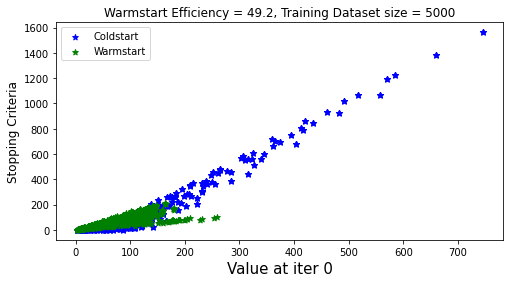

In [10]:
# Prove of convergence and efficiency of warmstart
# The stopping criteria should be lower when warmstarting in more than 90% of cases, as compared to coldstart.
c = []
c_cost = []
w = []
w_cost = []
for x in Data:
    
    model = crocoddyl.ActionModelUnicycle()
    model.costWeights = np.array([1.5, 1])
    problem = crocoddyl.ShootingProblem(x.T, [model]*20, model)
    ddp = crocoddyl.SolverDDP(problem)
    log = crocoddyl.CallbackLogger()
    ddp.setCallbacks([log])
    ddp.solve([],[], 1000)
    xs = np.array(ddp.xs)

    c.append(log.stops[1])
    c_cost.append(log.costs[0])
    guess = policy_net1_5000.warmstart_policy(torch.Tensor(x))

    model = crocoddyl.ActionModelUnicycle()
    model.costWeights = np.array([1.5, 1])
    problem = crocoddyl.ShootingProblem(x.T, [model]*20, model)
    ddp = crocoddyl.SolverDDP(problem)
    log = crocoddyl.CallbackLogger()
    ddp.setCallbacks([log])
    ddp.solve(guess,[], 1000)

    w.append(log.stops[0])

    w_cost.append(log.costs[0])
    
# Lets measure the efficiency of warmstarting

count = 0.
for i, j in zip(c, w):
    if j < i:
        count += 1
count = count / 10
print(f"Efficiency of warmstart is {count}%")        

plt.figure(figsize=(8, 4))
plt.scatter(c_cost, c, marker = "*", c = 'blue', label = "Coldstart")
plt.scatter(w_cost, w, marker = "*", c = 'green', label = "Warmstart")
plt.ylabel("Stopping Criteria", fontsize = 12)
plt.xlabel("Value at iter 0", fontsize = 15)
plt.title(f"Warmstart Efficiency = {count}, Training Dataset size = 5000")
plt.legend(loc ='upper left')

In [ ]:
# Now let's use terminal value model inside crocoddyl while warmstarting

In [ ]:
# Prove of convergence and efficiency of warmstart
# The stopping criteria should be lower when warmstarting in more than 90% of cases, as compared to coldstart.
c = []
c_cost = []
w = []
w_cost = []
for x in Data:
    
    model = crocoddyl.ActionModelUnicycle()
    model.costWeights = np.array([1.5, 1])
    problem = crocoddyl.ShootingProblem(x.T, [model]*20, model)
    ddp = crocoddyl.SolverDDP(problem)
    log = crocoddyl.CallbackLogger()
    ddp.setCallbacks([log])
    ddp.solve([],[], 1000)
    xs = np.array(ddp.xs)

    c.append(log.stops[1])
    c_cost.append(log.costs[1])
    
    guess = policy_net1_5000.warmstart_policy(torch.Tensor(x))

    model = crocoddyl.ActionModelUnicycle()
    terminal_model = ValueModelUnicycle(value_net1_5000)
    model.costWeights = np.array([1.5, 1])
    problem = crocoddyl.ShootingProblem(x.T, [model]*20, terminal_model)
    ddp = crocoddyl.SolverDDP(problem)
    log = crocoddyl.CallbackLogger()
    ddp.setCallbacks([log])
    ddp.solve(guess,[], 1000)

    w.append(log.stops[1])
    w_cost.append(log.costs[1])
    
# Lets measure the efficiency of warmstarting

count = 0.
for i, j in zip(c, w):
    if j < i:
        count += 1
count = count / 10
print(f"Efficiency of warmstart is {count}%")        

plt.figure(figsize=(8, 4))
plt.scatter(c_cost, c, marker = "*", c = 'blue', label = "Coldstart")
plt.scatter(w_cost, w, marker = "*", c = 'green', label = "Warmstart")
plt.ylabel("Stopping Criteria", fontsize = 12)
plt.xlabel("Value at iter 0", fontsize = 15)
plt.title(f"Warmstart Efficiency = {count}, Training Dataset size = 5000")
plt.legend(loc ='upper left')